# 3DeeCellTracker Demo: Ensemble mode | Use StarDist

This notebook shows how to use 3DeeCellTracker to track cells in ensemble mode.
The demo data can be found in the "single_mode_worm1" folder downloaded from https://osf.io/pgr95/

**The basic procedures:**
- A. Import packages
- B. Segment cells in all time points by StarDist3D
- C. Manually correct the segmentation at volume 1 and load it.
- D. Tracking.

**Please run following codes according to the instructions**
- Some codes can be skipped if unnecessary.

## A. Import packages

In [1]:
%load_ext autoreload
%autoreload 2
import os
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

import CellTracker.trackerlite as trl
import CellTracker.stardistwrapper as sdw
import CellTracker.coord_image_transformer as cit

## B. Segment cells in all time points by StarDist3D
### Load the trained StarDist3D model

In [2]:
model = sdw.load_stardist_model(model_name="stardist_02")

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.545286, nms_thresh=0.3.


2023-04-21 16:55:48.617708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 16:55:48.621396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 16:55:48.621817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-21 16:55:48.622334: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### Segment the volume #1 image and save the results as tiff images

image_shape=(128, 168, 401)


2023-04-21 16:55:51.558365: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-21 16:55:52.059064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


prob_map.shape=(64, 84, 201)


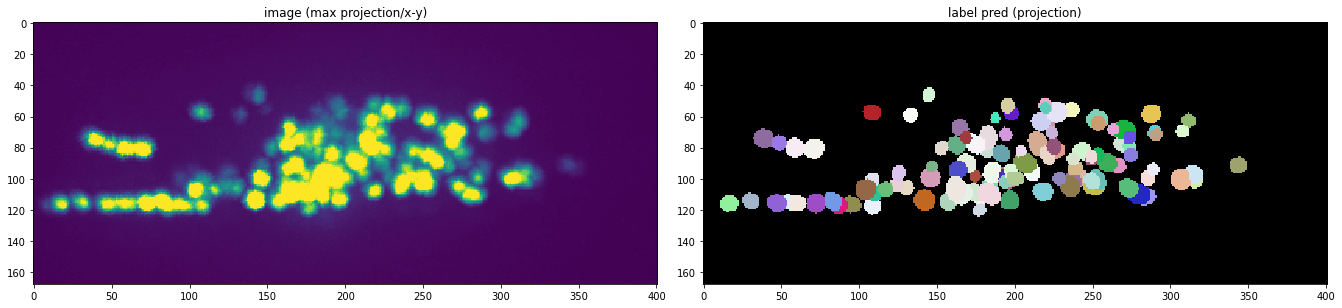

In [3]:
# Set the initial volume number
vol = 1

path_results = "./worm_sd02/"

# Set the file path for the raw images
path_raw_images = "./worm_sd02/data/*t%04d*.tif"

# Load 2D slices of the image stack at the current volume
x = sdw.load_2d_slices_at_time(slice_paths=path_raw_images, t=vol)

# Get the shape of the loaded images
image_shape = x.shape
print(f"{image_shape=}")

# Predict instance labels and details using a trained model
(labels, details), prob_map = model.predict_instances(x)
print(f"{prob_map.shape=}")

# ys = model.keras_model.predict(x[None,:,:,:])
# print(ys[0])

# Plot the maximum projection of the predicted instance labels
sdw.plot_img_label_max_projection(x, labels, lbl_title="label pred (projection)", fig_width_px=1800)

# Determine whether to use 8-bit or 16-bit image format
use_8_bit = True if labels.max() <= 255 else False

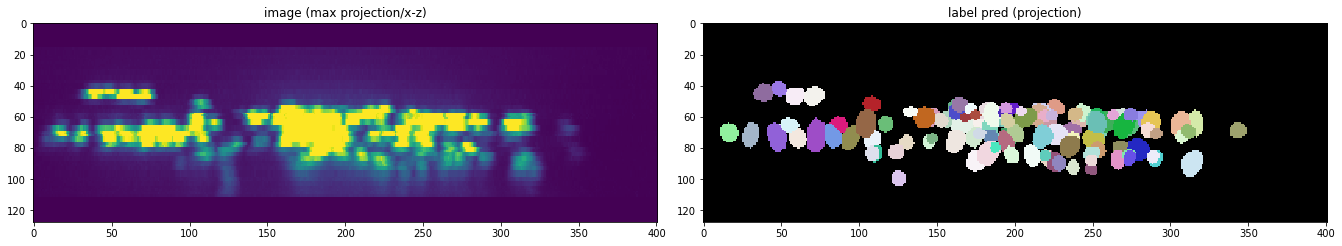

In [4]:
sdw.plot_img_label_max_projection_xz(x, labels, lbl_title="label pred (projection)", fig_width_px=1800, scale_z=1)

### Segment all volumes and save the coordinates of predicted cell centers

In [5]:
sdw.predict_and_save(images_path=path_raw_images, model=model, results_folder=path_results)

Segmenting images: 100%|█| 80/80 [01:36<00:00,  1.

All images from t=1 to t=80 have been Segmented


## C. Manually correct the segmentation at volume 1 and load it.

**C1. Manual correction and move files to the folder**
- Delete non-cell regions;
- Add cells not labeled; 
- correct cell boundaries in other software (such as ITK-SNAP)

- save the corrected segmentation as 2D images (with different z)
- Move the corrected segmentation to the created "/manual_vol1" folder

**C2. Load the manually corrected segmentation**

Loaded the proofed segmentations at vol 1 with 113 cells


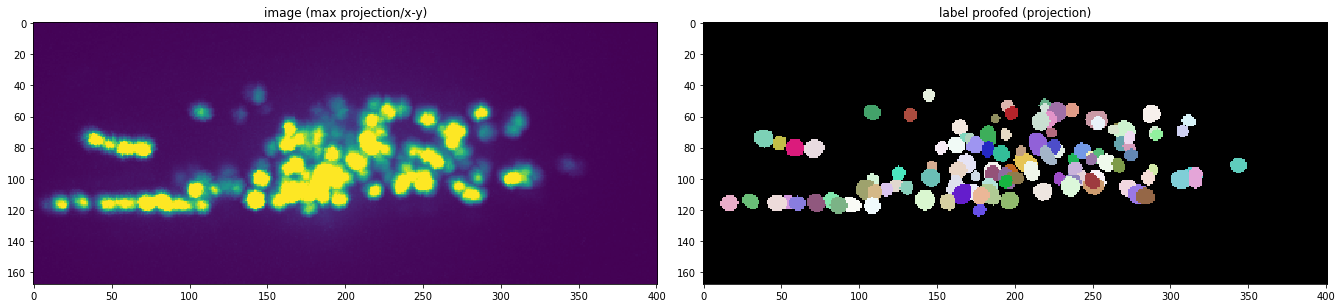

In [6]:
voxel_size=(1, 1, 1)

manual_seg_path="./worm_sd02/manual_vol1/*.tif"

coords2image = cit.CoordsToImageTransformer(results_folder=path_results, voxel_size=voxel_size)
coords2image.load_segmentation(manual_vol1_path=manual_seg_path)
sdw.plot_img_label_max_projection(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800)

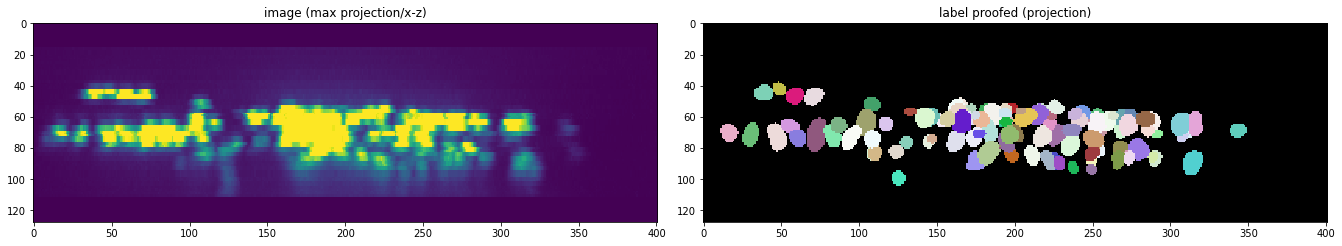

In [7]:
sdw.plot_img_label_max_projection_xz(x, coords2image.proofed_segmentation.transpose(2,0,1), lbl_title="label proofed (projection)", fig_width_px=1800, scale_z=1)

**C3. Interpolate cells to make more smooth cell boundary**

In [8]:
coords2image.interpolate(interpolation_factor=1)

Interpolating images along z-axis...
The interpolated segmentations at vol 1 contains 113 cells
Calculating coordinates of cell centers...


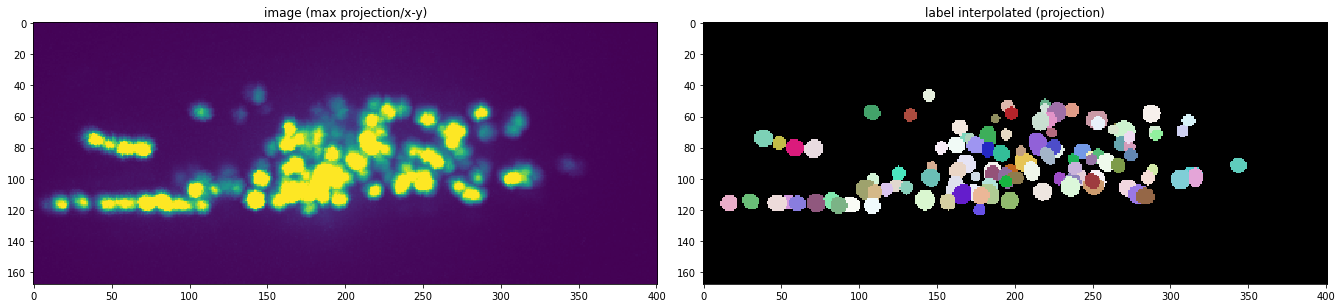

In [9]:
sdw.plot_img_label_max_projection(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800)

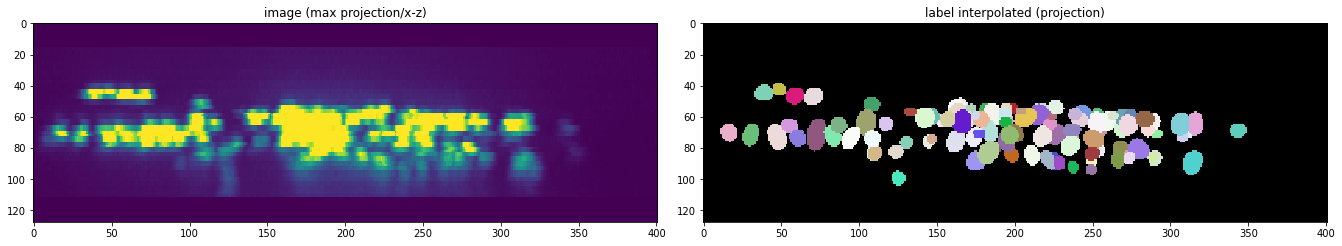

In [10]:
sdw.plot_img_label_max_projection_xz(x, coords2image.auto_corrected_segmentation.transpose(2,0,1), lbl_title="label interpolated (projection)", fig_width_px=1800,scale_z=1)

## D. Tracking. 
**D1. Set paths**

In [11]:
ffn_model_path="./ffn_model/ffn_02.h5"

tracker = trl.TrackerLite(results_dir=path_results, ffn_model_path=ffn_model_path, proofed_coords_vol1=coords2image.coord_vol1)

2023-04-21 16:58:00.373230: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


**D2. Test ffn matching**

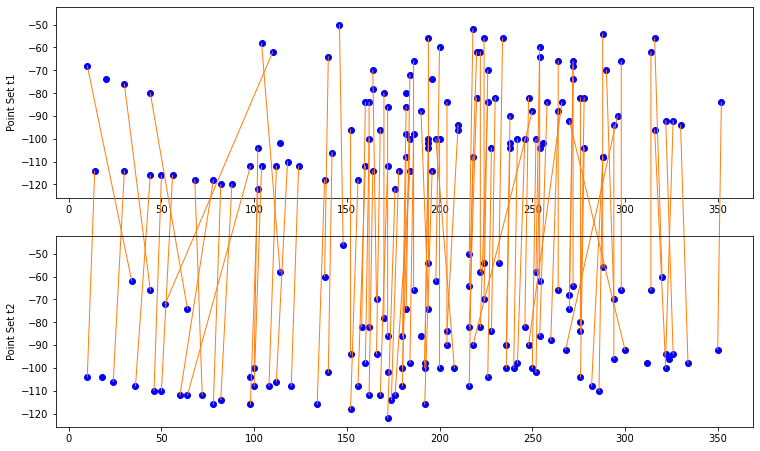

In [12]:
tracker.match_by_ffn(t1=14, t2=15)

**D3. Test FFN + PR-GLS prediction**

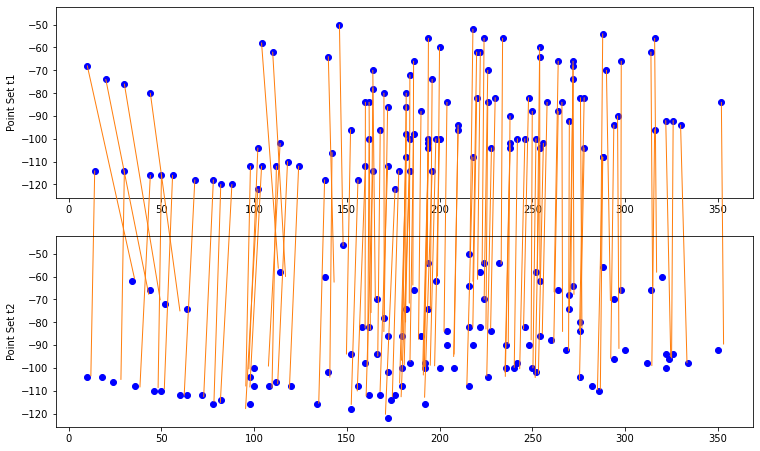

In [13]:
beta, lambda_= (3, 3)

tracked_positions_t2 = tracker.predict_cell_positions(t1=14, t2=15, beta=beta, lambda_=lambda_, draw_fig=True)

**D4. Track all following volumes**

In [14]:
t_start, t_end = (1, 80)
skip_volumes = [79]
ensemble = True

t1 = t_start
confirmed_coord = coords2image.coord_vol1
grid = model.config.grid
for t in range(t_start+1, t_end+1):
    print(f"t={t}...", end="\r")
    if t in skip_volumes:
        print(f"skip t={t}")
        continue
    coord_prgls = tracker.predict_cell_positions_ensemble(skip_volumes=skip_volumes, t2=t, coord_t1=confirmed_coord, beta=beta, lambda_=lambda_, 
                                                          sampling_number=20, adjacent=False)
    t1 = t
    confirmed_coord, corrected_labels_image = coords2image.accurate_correction(t, grid, coord_prgls, ensemble)
    coords2image.save_tracking_results(confirmed_coord, corrected_labels_image, tracker, t1=t1, t2=t, images_path=path_raw_images)

skip t=79
